# Training an USE[DAN] Model

This Notebook defines a pipeline to train a dense neural network based on a DAN-Model. You can chose two settings: 

1. All your input text is treated as normal text
2. Your input text file will be splitt up in sentences

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
from nltk.tokenize import sent_tokenize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

## General Information & Label Map

### Directories

In [92]:
classifier_name = "test_model" # Name of the model is at the same time the dir where model files will be stored
classifier_dir = os.path.abspath(classifier_name)
# label_map = "" # path to label map (not implemented yet..)
data_dir = "../data/datasets/daniel_0212" # Where text data are stored
test_dir = "../data/eval_data"

In [4]:
if not os.path.isdir(classifier_dir):
    os.mkdir(classifier_dir)
    print("model dir created!")
else:
    print("model dir already exists")

model dir already exists


### Model (Classifier) & Training Parameters

In [91]:
# Training Parameters
batch_size = 10
num_epochs = 100
training_steps = None

# Model Parameters
num_classes = 4 # ADJUST THAT
hidden_units = [1024,512,256,64] # Iterable of number hidden units per layer. 
activation_fn=tf.nn.relu
optimizer = tf.train.AdadeltaOptimizer(learning_rate=0.001)
dropout = None # None or float 0-1
batch_normalization = False
regularization = False

### Label Map

In [51]:
# Use the label_map class from you package..
def get_label_id(class_name:str):
    if class_name == "clustering":   
        return 0
    if class_name == "pattern_mining":
        return 1
    if class_name == "regression":
        return 2
    if class_name == "classification":
        return 3

## Environment for TF-HUB Model

In [66]:
# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)

In [67]:
# I dont know if he overwrites the model during retraining.
embedding_model_url = "https://tfhub.dev/google/universal-sentence-encoder/2" 

In [68]:
import hashlib
# The path where tf-hub will cache the model (use an absolute path..) 
os.environ["TFHUB_CACHE_DIR"] = os.path.join(classifier_dir, "embedding_model")

#TF-hub will store the name as hex
embedding_model_hash = hashlib.sha1(classifier_dir.encode("utf8")).hexdigest()
print(embedding_model_hash)

419b2b3084fae7c4784fd6ce806e7ef02ec4c87a


## Loading Data into Dataframe

In [11]:
from nltk.tokenize import sent_tokenize

In [12]:
def read_data(_dir:str, sentence_level = True):
    data = {}
    data["text"] = []
    data["class"] = []
    for root, dirs, files in os.walk(_dir):
        for _dir in dirs: 
            for txt_file in [x for x in os.listdir(os.path.join(root, _dir)) if x.endswith((".txt", ".TXT"))]:
                # Class name = dir name
                class_name = _dir
                #Read File
                file_name = os.path.join(root, _dir, txt_file)
                file = open(file_name, "r")
                txt = file.read()
                file.close()
                if sentence_level:
                    # Txt to List[Sentences]
                    sentences = sent_tokenize(txt)
                    # Abstracts
                    for sentence in sentences:
                        data["text"].append(sentence)
                        data["class"].append(get_label_id(class_name))
                else:
                    data["text"].append(text)
                    data["class"].append(get_label_id(class_name))
    df = pd.DataFrame.from_dict(data)
    del data
    return df

In [13]:
%%time
df = read_data(data_dir)

CPU times: user 4.86 s, sys: 1.13 s, total: 5.99 s
Wall time: 7.33 s


## Data Overview

In [14]:
df.sample(frac=1).head()

,text,class
21835,"Particularly, the\nMMC network is developed to...",1
15088,The function parameters are searched with an e...,1
1424,"Numerous social, medical, engineering and biol...",3
14510,Traditional EM imaging based on\nhomogeneous r...,1
34320,Work on clustering similar households has conc...,0


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58243 entries, 0 to 58242
Data columns (total 2 columns):
text     58243 non-null object
class    58243 non-null int64
dtypes: int64(1), object(1)
memory usage: 910.1+ KB


## Train and Test Split

In [16]:
df = shuffle(df) # Shuffle the DataFrame
X, Y = train_test_split(df, test_size=0.2, random_state = 101)

In [17]:
X.head(3)

,text,class
11774,"In this paper, we present a method to reveal v...",3
18209,Brain computer interface is the current area o...,1
19217,"As such, SBIC uses an embedded mechanism for s...",1


In [18]:
Y.head(3)

,text,class
37474,Extensive simulations\nshow the superior perfo...,0
56133,For these estimators we prove Fisher-consisten...,2
5910,Probabilistic k-nearest neighbour (PKNN) class...,3


In [19]:
print("Train Data: \n")
print(X.info())
print("\n Test Data: \n")
print(Y.info())

Train Data: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46594 entries, 11774 to 54040
Data columns (total 2 columns):
text     46594 non-null object
class    46594 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.1+ MB
None

 Test Data: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11649 entries, 37474 to 25986
Data columns (total 2 columns):
text     11649 non-null object
class    11649 non-null int64
dtypes: int64(1), object(1)
memory usage: 273.0+ KB
None


## Training

### Constructing Feature Columns

In [20]:
%%time
tf.logging.set_verbosity(tf.logging.INFO)
embedded_text_feature_column = hub.text_embedding_column(
    key="text", 
    module_spec=embedding_model_url,
    trainable = True)

CPU times: user 116 ms, sys: 8.87 ms, total: 125 ms
Wall time: 131 ms


In [21]:
tf.logging.set_verbosity(tf.logging.ERROR) # Reduce the stupid tf-warnings

In [22]:
estimator = tf.estimator.DNNClassifier(
    hidden_units= hidden_units,
    feature_columns=[embedded_text_feature_column],
    model_dir = classifier_dir,
    activation_fn=activation_fn,
    n_classes=num_classes,
    dropout = dropout,
    batch_norm=batch_normalization,
    optimizer=optimizer)

### Defining Input Functions

In [23]:
# Training input on the whole training set with no limit on training epochs.
train_input_fn = tf.estimator.inputs.pandas_input_fn(
    X, 
    X["class"],
    num_epochs=num_epochs,
    batch_size= batch_size,
    shuffle = False)

# Prediction on the whole training set.
predict_train_input_fn = tf.estimator.inputs.pandas_input_fn(
    X, X["class"], shuffle=False)

# Prediction on the test set.
predict_test_input_fn = tf.estimator.inputs.pandas_input_fn(
    Y, Y["class"], shuffle=False)

### Training of the Classifier

In [24]:
%%time
tf.logging.set_verbosity(tf.logging.INFO)
estimator.train(input_fn=train_input_fn, steps=training_steps);

Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Saving checkpoints for 0 into /Users/Daniel/PycharmProjects/Recommender-System/notebooks/test_model/model.ckpt.
INFO:tensorflow:loss = 13.930591, step = 1
INFO:tensorflow:Saving checkpoints for 1 into /Users/Daniel/PycharmProjects/Recommender-System/notebooks/test_model/model.ckpt.
INFO:tensorflow:Loss for final step: 

## Evaluation

In [36]:
tf.logging.set_verbosity(tf.logging.ERROR)

In [37]:
def get_predictions(estimator, input_fn):
    return [x["class_ids"][0] for x in estimator.predict(input_fn=input_fn)]

In [38]:
labels = ["clustering", "association", "regression", "classification"]

### Insampling

In [39]:
results = estimator.evaluate(input_fn=predict_train_input_fn)

print("Results: \n")
print(results)

Results: 

{'accuracy': 0.25599864, 'average_loss': 1.3835783, 'loss': 176.62039, 'global_step': 1}


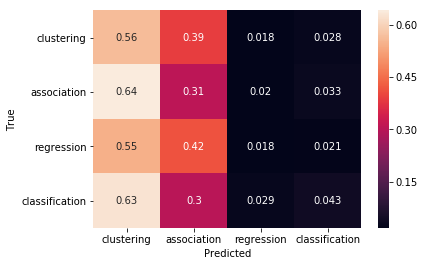

In [41]:
with tf.Graph().as_default():
    cm = tf.confusion_matrix(X["class"], get_predictions(estimator, predict_train_input_fn))
    with tf.Session() as session:
        cm_out = session.run(cm)

# Normalize the confusion matrix so that each row sums to 1.
cm_out = cm_out.astype(float) / cm_out.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_out, annot=True, xticklabels=labels, yticklabels=labels);
plt.xlabel("Predicted");
plt.ylabel("True");

### Outsampling

In [42]:
results = estimator.evaluate(input_fn=predict_test_input_fn)

print("Results: \n")
print(results)

Results: 

{'accuracy': 0.25452828, 'average_loss': 1.3835768, 'loss': 175.18788, 'global_step': 1}


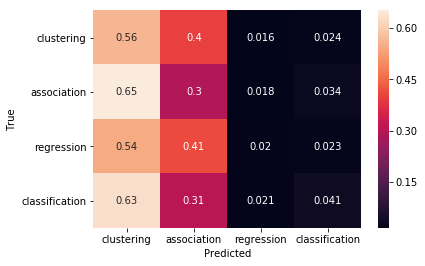

In [43]:
with tf.Graph().as_default():
    cm = tf.confusion_matrix(Y["class"], get_predictions(estimator, predict_test_input_fn))
    with tf.Session() as session:
        cm_out = session.run(cm)

# Normalize the confusion matrix so that each row sums to 1.
cm_out = cm_out.astype(float) / cm_out.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_out, annot=True, xticklabels=labels, yticklabels=labels);
plt.xlabel("Predicted");
plt.ylabel("True");

### Test Set

#### Read Test Data

In [52]:
df_test = read_data(test_dir, sentence_level = False)

In [54]:
shuffle(df_test.head(5))

,text,class
4,The main objective is to detect different car ...,3
2,Given a arbitrary text of the world library th...,3
1,Not based on numerical features.,3
0,I want a forecasting of the used machine types...,3
3,The project describes the problem of recognizi...,3


#### Defining Input Function

In [55]:
# Prediction on the whole training set.
predict_test_input_fn = tf.estimator.inputs.pandas_input_fn(
    df_test, df_test["class"], shuffle=True)

#### Evaluation of Test Set

In [56]:
results = estimator.evaluate(input_fn=predict_test_input_fn)

print("Results: \n")
print(results)

Results: 

{'accuracy': 0.3, 'average_loss': 1.3803766, 'loss': 27.607533, 'global_step': 1}


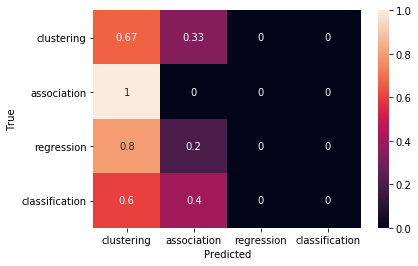

In [57]:
with tf.Graph().as_default():
    cm = tf.confusion_matrix(df_test["class"], get_predictions(estimator, predict_test_input_fn))
    with tf.Session() as session:
        cm_out = session.run(cm)

# Normalize the confusion matrix so that each row sums to 1.
cm_out = cm_out.astype(float) / cm_out.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_out, annot=True, xticklabels=labels, yticklabels=labels);
plt.xlabel("Predicted");
plt.ylabel("True");

### Semantic Textual Similarity

#### Function and Sentences for Similarity Matrix

In [58]:
def plot_similarity(labels, features, rotation):
    corr = np.inner(features, features)
    sns.set(font_scale=1.2)
    g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Semantic Textual Similarity")


def run_and_plot(session_, input_tensor_, messages_, encoding_tensor):
    message_embeddings_ = session_.run(
      encoding_tensor, feed_dict={input_tensor_: messages_})
    plot_similarity(messages_, message_embeddings_, 90)

In [62]:
clustering_0 = "finding similar groups"
clustering_1 = "clustering things"
pattern_mining_0 = "analysing sequences"
pattern_mining_1 = "finding pattern"
classification_0 = "predicting categorical types"
classification_1 = "classifing objects"
regression_0 = "predicting prices"
regression_1 = "forecasting numbers"

messages = [clustering_0,
            clustering_1,
            pattern_mining_0,
            pattern_mining_1,
            classification_0,
            classification_1,
            regression_0,
            regression_1]

#### Similarity Matrix

In [64]:
%%time
# Initial download takes a while till the model is downloaded from tf-hub (~1GB)
tf.logging.set_verbosity(tf.logging.INFO)
model = hub.Module(embedding_model_url, trainable = False) # trainable = True for Transfer Learning!!

CPU times: user 1.53 s, sys: 41.5 ms, total: 1.57 s
Wall time: 1.59 s


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


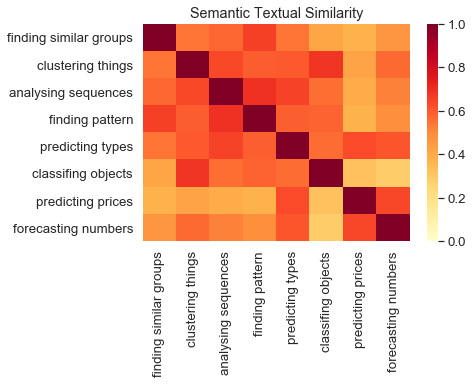

In [65]:
similarity_input_placeholder = tf.placeholder(tf.string, shape=(None))
similarity_message_encodings = model(similarity_input_placeholder)

with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    
    run_and_plot(session, similarity_input_placeholder, messages,
               similarity_message_encodings)

## Inference for each Test Data File

In [80]:
df_inference = pd.DataFrame.from_dict({"text": df_test["text"]})
inference_func = tf.estimator.inputs.pandas_input_fn(df_inference, shuffle=False)

In [89]:
results = estimator.predict(inference_func)
y = []
probs =[]
for x in results:
    y.append(x["class_ids"])
    probs.append(x["probabilities"])
df_test["predicted"] = y
df_test["probs"] = probs

In [90]:
pd.set_option('display.max_colwidth', -1)
df_test

,text,class,predicted,probs
0,I want a forecasting of the used machine types in my assembly line.,3,[0],"[0.26093316, 0.25915012, 0.25016004, 0.22975671]"
1,Not based on numerical features.,3,[0],"[0.25667354, 0.25535163, 0.24522372, 0.24275109]"
2,Given a arbitrary text of the world library the software should classify the author.,3,[0],"[0.26328275, 0.25517595, 0.23295455, 0.24858673]"
3,The project describes the problem of recognizing objects in images.,3,[0],"[0.26405403, 0.24664634, 0.24863827, 0.24066138]"
4,The main objective is to detect different car brands in one picture.,3,[0],"[0.26617894, 0.25238276, 0.23944362, 0.24199477]"
5,"The purpose of this project is to segment supply chain partners in the automobile industry, according to their provided quality.",0,[0],"[0.2643476, 0.25394645, 0.25034013, 0.23136574]"
6,Our company has a variety of different costumers.,0,[0],"[0.26106918, 0.25313938, 0.24082673, 0.24496472]"
7,"Based on the costumer types as well of their revenues, different costumer groups should be found.",0,[0],"[0.26276815, 0.24651077, 0.25111374, 0.23960736]"
8,I want to group my machines according to their energy consumption.,0,[1],"[0.2512538, 0.2602064, 0.24818558, 0.24035424]"
9,Machines with a similar energy consumption should be grouped together.,0,[0],"[0.26045293, 0.25245857, 0.2506396, 0.23644893]"
